## AWS Multi-format Streaming Pipeline

This notebook demonstrates how to build a cloud-based streaming pipeline on AWS that 
can handle multiple data formats (JSON, CSV, and binary) in a unified way.

## What You'll Learn
- Setting up AWS streaming resources using boto3
- Sending data in multiple formats to Kinesis
- Processing different formats with Lambda
- Storing standardized results in S3
- Monitoring your pipeline with CloudWatch

## Prerequisites
- An AWS account with appropriate permissions
- AWS credentials configured locally or in your notebook environment
- Basic knowledge of AWS services (Kinesis, Lambda, S3)

## Setup AWS Resources
First, we'll install required packages and set up the AWS resources needed for our demonstration:

In [1]:
# Install required packages
!pip install boto3 pandas matplotlib seaborn

# Import required libraries
import boto3
import json
import csv
import io
import struct
import base64
import time
import uuid
import datetime
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure AWS session
import boto3
session = boto3.Session(region_name='ap-south-1')  # Change to your preferred region

# Initialize AWS service clients
kinesis_client = session.client('kinesis')
lambda_client = session.client('lambda')
s3_client = session.client('s3')
iam_client = session.client('iam')
cloudwatch_client = session.client('cloudwatch')

# Generate unique names for our resources to avoid conflicts
unique_id = str(uuid.uuid4())[:8]
STREAM_NAME = f"multi-format-stream-{unique_id}"
S3_BUCKET_NAME = f"multi-format-demo-{unique_id}"
LAMBDA_FUNCTION_NAME = f"multi-format-processor-{unique_id}"
LAMBDA_ROLE_NAME = f"multi-format-lambda-role-{unique_id}"

print(f"Generated unique names for AWS resources:")
print(f"- Kinesis Stream: {STREAM_NAME}")
print(f"- S3 Bucket: {S3_BUCKET_NAME}")
print(f"- Lambda Function: {LAMBDA_FUNCTION_NAME}")

/Users/sanjij/anaconda3/envs/geo/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Generated unique names for AWS resources:
- Kinesis Stream: multi-format-stream-7855382b
- S3 Bucket: multi-format-demo-7855382b
- Lambda Function: multi-format-processor-7855382b


In [2]:
# Create infrastructure with proper error handling

def create_aws_resources():
    """Create the necessary AWS resources for our streaming demo"""
    resources_created = []
    
    try:
        # Create a Kinesis stream
        print("Creating Kinesis stream...")
        kinesis_client.create_stream(
            StreamName=STREAM_NAME,
            ShardCount=1
        )
        resources_created.append(f"Kinesis stream: {STREAM_NAME}")
        
        # Wait for stream to become active
        print("Waiting for stream to become active...")
        kinesis_client.get_waiter('stream_exists').wait(StreamName=STREAM_NAME)
        
        # Create an S3 bucket
        print("Creating S3 bucket...")
        s3_client.create_bucket(
            Bucket=S3_BUCKET_NAME,
            CreateBucketConfiguration={
                'LocationConstraint': session.region_name
            } if session.region_name != 'us-east-1' else {}
        )
        resources_created.append(f"S3 bucket: {S3_BUCKET_NAME}")
        
        # Create IAM role for Lambda
        print("Creating IAM role for Lambda...")
        assume_role_policy = {
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {"Service": "lambda.amazonaws.com"},
                    "Action": "sts:AssumeRole"
                }
            ]
        }
        
        response = iam_client.create_role(
            RoleName=LAMBDA_ROLE_NAME,
            AssumeRolePolicyDocument=json.dumps(assume_role_policy)
        )
        resources_created.append(f"IAM role: {LAMBDA_ROLE_NAME}")
        
        lambda_role_arn = response['Role']['Arn']
        
        # Attach policies to the role
        print("Attaching policies to IAM role...")
        iam_client.attach_role_policy(
            RoleName=LAMBDA_ROLE_NAME,
            PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole'
        )
        
        iam_client.attach_role_policy(
            RoleName=LAMBDA_ROLE_NAME,
            PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaKinesisExecutionRole'
        )
        
        iam_client.attach_role_policy(
            RoleName=LAMBDA_ROLE_NAME,
            PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess'
        )
        
        # Wait for role permissions to propagate
        print("Waiting for IAM role permissions to propagate...")
        time.sleep(10)
        
        print("AWS resources created successfully.")
        return lambda_role_arn, resources_created
    
    except Exception as e:
        print(f"Error creating AWS resources: {str(e)}")
        # Print which resources were created for cleanup
        print("Resources created before error:")
        for resource in resources_created:
            print(f"- {resource}")
        return None, resources_created

# Create the resources
lambda_role_arn, created_resources = create_aws_resources()

Creating Kinesis stream...
Waiting for stream to become active...
Creating S3 bucket...
Creating IAM role for Lambda...
Attaching policies to IAM role...
Waiting for IAM role permissions to propagate...
AWS resources created successfully.


## Data Generation

Let's create functions to generate equivalent data in three different formats and send them to our Kinesis stream:
1. **JSON**: A structured text format using key-value pairs
2. **CSV**: A comma-separated values text format
3. **Binary**: A compact binary representation

All three formats will contain the same information:
- Device ID
- Timestamp
- Sensor readings (temperature and humidity)

In [3]:
def generate_json_data(device_id="device-001", temp=72.5, humidity=45.2):
    """Generate sample data in JSON format"""
    
    data = {
        "format": "json",
        "timestamp": datetime.datetime.now().isoformat(),
        "deviceId": device_id,
        "readings": {
            "temperature": temp,
            "humidity": humidity
        }
    }
    
    return json.dumps(data).encode('utf-8')

def generate_csv_data(device_id="device-001", temp=72.5, humidity=45.2):
    """Generate sample data in CSV format"""
    
    timestamp = datetime.datetime.now().isoformat()
    
    # Create a CSV string with a header row
    output = io.StringIO()
    writer = csv.writer(output)
    
    # Write format identifier
    output.write("format,csv\n")
    
    # Write header
    writer.writerow(["timestamp", "deviceId", "reading_type", "value"])
    
    # Write data rows - one row per reading
    writer.writerow([timestamp, device_id, "temperature", temp])
    writer.writerow([timestamp, device_id, "humidity", humidity])
    
    return output.getvalue().encode('utf-8')

def generate_binary_data(device_id="device-001", temp=72.5, humidity=45.2):
    """Generate sample data in a binary format"""
    
    # Get current timestamp as seconds since epoch
    timestamp = datetime.datetime.now().timestamp()
    
    # Convert device ID to bytes
    device_id_bytes = device_id.encode('utf-8')
    device_id_length = len(device_id_bytes)
    
    # Format marker
    format_id = b'BIN\0'
    
    # Pack binary data
    data = struct.pack(
        f'4sdB{device_id_length}sff',
        format_id,
        timestamp,
        device_id_length,
        device_id_bytes,
        temp,
        humidity
    )
    
    return data

def send_to_kinesis(data, partition_key):
    """Send data to Kinesis stream"""
    response = kinesis_client.put_record(
        StreamName=STREAM_NAME,
        Data=data,
        PartitionKey=partition_key
    )
    return response

## Lambda Function for Processing

Now we'll create a Lambda function that can detect and process different data formats from Kinesis, 
then store the standardized results in S3.

In [5]:
lambda_code = """
import json
import base64
import boto3
import csv
import io
import struct
import time
from datetime import datetime

# Initialize S3 client
s3_client = boto3.client('s3')

# S3 bucket for processed results
BUCKET_NAME = '{S3_BUCKET_NAME}'

def process_json_data(data):
    #Process JSON format data
    # Parse the JSON data
    parsed = json.loads(data)
    
    # Extract fields
    timestamp = parsed.get('timestamp')
    device_id = parsed.get('deviceId')
    readings = parsed.get('readings', {{}})
    
    # Create standardized output
    processed = {{
        'original_format': 'json',
        'processed_timestamp': datetime.utcnow().isoformat(),
        'device_id': device_id,
        'event_timestamp': timestamp,
        'readings': readings,
        'source': 'simulator'
    }}
    
    return processed

def process_csv_data(data):
    #Process CSV format data
    # Parse CSV data
    lines = data.strip().split('\\n')
    
    # Extract format line
    if not lines[0].startswith('format,csv'):
        raise ValueError("Invalid CSV format - missing format header")
    
    # Parse the CSV content
    reader = csv.reader(io.StringIO('\\n'.join(lines[1:])))
    headers = next(reader)
    
    # Group readings by device and timestamp
    readings = {{}}
    timestamp = None
    device_id = None
    
    for row in reader:
        record = dict(zip(headers, row))
        
        # Use the first timestamp and device_id we find
        if timestamp is None:
            timestamp = record.get('timestamp')
        if device_id is None:
            device_id = record.get('deviceId')
            
        reading_type = record.get('reading_type')
        value = record.get('value')
        
        if reading_type and value:
            readings[reading_type] = float(value)
    
    # Create standardized output
    processed = {{
        'original_format': 'csv',
        'processed_timestamp': datetime.utcnow().isoformat(),
        'device_id': device_id,
        'event_timestamp': timestamp,
        'readings': readings,
        'source': 'simulator'
    }}
    
    return processed

def process_binary_data(data):
    #Process binary format data
    # Check for minimum viable length
    if len(data) < 13:  # 4+8+1 minimum header
        raise ValueError("Binary data too short")
    
    # Unpack the format ID and verify
    format_id = data[0:4]
    if format_id != b'BIN\\0':
        raise ValueError(f"Invalid binary format ID: {{format_id}}")
    
    # Unpack fixed header
    timestamp = struct.unpack('d', data[4:12])[0]
    device_id_length = struct.unpack('B', data[12:13])[0]
    
    # Calculate positions
    device_id_end = 13 + device_id_length
    
    # Unpack device ID
    device_id = data[13:device_id_end].decode('utf-8')
    
    # Unpack readings
    readings_data = data[device_id_end:]
    if len(readings_data) >= 8:  # 2 floats * 4 bytes
        temperature, humidity = struct.unpack('ff', readings_data[:8])
        
        readings = {{
            'temperature': temperature,
            'humidity': humidity
        }}
    else:
        readings = {{}}
    
    # Create standardized output
    processed = {{
        'original_format': 'binary',
        'processed_timestamp': datetime.utcnow().isoformat(),
        'device_id': device_id,
        'event_timestamp': datetime.fromtimestamp(timestamp).isoformat(),
        'readings': readings,
        'source': 'simulator'
    }}
    
    return processed

def detect_and_process_data(data):
    #Detect data format and process accordingly
    try:
        # Check if it's JSON
        if data.startswith(b'{{') and data.endswith(b'}}'):
            data_str = data.decode('utf-8')
            parsed = json.loads(data_str)
            if parsed.get('format') == 'json':
                return process_json_data(data_str)
        
        # Check if it's CSV
        if data.startswith(b'format,csv'):
            return process_csv_data(data.decode('utf-8'))
        
        # Try as binary (check for BIN\\0 header)
        if data.startswith(b'BIN\\0'):
            return process_binary_data(data)
        
        # If we get here, we couldn't detect the format
        raise ValueError("Unknown data format")
    
    except Exception as e:
        # Log and return error response
        print(f"Error processing data: {{str(e)}}")
        return {{
            'error': str(e),
            'data_sample': str(data[:100]),
            'processed_timestamp': datetime.utcnow().isoformat()
        }}

def save_to_s3(processed_data, original_format):
    #Save processed data to S3 with appropriate partitioning
    # Create a timestamp-based key for partitioning
    now = datetime.utcnow()
    key = f"{{original_format}}/year={{now.year}}/month={{now.month:02d}}/day={{now.day:02d}}/hour={{now.hour:02d}}/{{processed_data['device_id']}}-{{int(time.time())}}.json"
    
    # Upload to S3
    s3_client.put_object(
        Bucket=BUCKET_NAME,
        Key=key,
        Body=json.dumps(processed_data),
        ContentType='application/json'
    )
    
    return {{
        'bucket': BUCKET_NAME,
        'key': key
    }}

def lambda_handler(event, context):
    #Lambda function to process multi-format data from Kinesis"
    processed_count = 0
    error_count = 0
    results = []
    
    for record in event['Records']:
        # Get the data
        payload = base64.b64decode(record['kinesis']['data'])
        
        # Detect format and process
        processed = detect_and_process_data(payload)
        
        # Check for errors
        if 'error' in processed:
            error_count += 1
            original_format = 'error'
        else:
            processed_count += 1
            original_format = processed.get('original_format', 'unknown')
            results.append(processed)
        
        # Save to S3
        s3_result = save_to_s3(processed, original_format)
        
        # Log result
        print(f"Processed {{original_format}} data: {{s3_result['key']}}")
    
    return {{
        'statusCode': 200,
        'body': json.dumps({{
            'processed_count': processed_count,
            'error_count': error_count,
            'results': results
        }})
    }}
""".format(S3_BUCKET_NAME=S3_BUCKET_NAME)

def create_lambda_function():
    """Create the Lambda function for processing multi-format data"""
    try:
        # Write Lambda code to a ZIP file
        import io
        import zipfile
        
        zip_buffer = io.BytesIO()
        with zipfile.ZipFile(zip_buffer, 'w') as zip_file:
            zip_file.writestr('lambda_function.py', lambda_code)
        
        zip_buffer.seek(0)
        
        # Create the Lambda function
        print("Creating Lambda function...")
        response = lambda_client.create_function(
            FunctionName=LAMBDA_FUNCTION_NAME,
            Runtime='python3.9',
            Role=lambda_role_arn,
            Handler='lambda_function.lambda_handler',
            Code={
                'ZipFile': zip_buffer.read()
            },
            Timeout=30,
            MemorySize=256
        )
        
        # Wait for function to be active
        print("Waiting for Lambda function to be active...")
        time.sleep(5)
        
        # Create event source mapping to Kinesis
        print("Creating event source mapping to Kinesis stream...")
        lambda_client.create_event_source_mapping(
            EventSourceArn=f"arn:aws:kinesis:{session.region_name}:{boto3.client('sts').get_caller_identity()['Account']}:stream/{STREAM_NAME}",
            FunctionName=LAMBDA_FUNCTION_NAME,
            StartingPosition='LATEST',
            BatchSize=10
        )
        
        print("Lambda function created and configured successfully.")
        return True
    
    except Exception as e:
        print(f"Error creating Lambda function: {str(e)}")
        return False

# Create the Lambda function
create_lambda_function()

Creating Lambda function...
Waiting for Lambda function to be active...
Creating event source mapping to Kinesis stream...
Lambda function created and configured successfully.


True

## Sending Test Data to Kinesis

Now let's send some test data in different formats to our Kinesis 
stream and watch the Lambda function process it.

In [6]:
def send_test_data():
    """Send test data in multiple formats to Kinesis"""
    results = []
    
    # Send JSON data
    json_data = generate_json_data("device-001", 72.5, 45.2)
    json_response = send_to_kinesis(json_data, "json-device-001")
    print(f"Sent JSON data: {json_response['SequenceNumber']}")
    results.append({"format": "JSON", "sequence": json_response['SequenceNumber']})
    
    # Wait a bit
    time.sleep(1)
    
    # Send CSV data
    csv_data = generate_csv_data("device-002", 68.0, 52.1)
    csv_response = send_to_kinesis(csv_data, "csv-device-002")
    print(f"Sent CSV data: {csv_response['SequenceNumber']}")
    results.append({"format": "CSV", "sequence": csv_response['SequenceNumber']})
    
    # Wait a bit
    time.sleep(1)
    
    # Send Binary data
    binary_data = generate_binary_data("device-003", 75.8, 39.7)
    binary_response = send_to_kinesis(binary_data, "binary-device-003")
    print(f"Sent Binary data: {binary_response['SequenceNumber']}")
    results.append({"format": "Binary", "sequence": binary_response['SequenceNumber']})
    
    return results

# Send the test data
test_results = send_test_data()

# Wait for processing
print("\nWaiting for Lambda to process the data (30 seconds)...")
time.sleep(30)

Sent JSON data: 49661319937669720816621530426826147599836834204466806786
Sent CSV data: 49661319937669720816621530427013531101877101795265740802
Sent Binary data: 49661319937669720816621530427249271636701954553052921858

Waiting for Lambda to process the data (30 seconds)...


## Verifying Processed Data

Let's check S3 to see the processed results and verify that our pipeline is working correctly.

In [7]:
def check_s3_results():
    """Check S3 for processed results"""
    try:
        print("Checking S3 for processed files...")
        
        # List objects in the bucket
        response = s3_client.list_objects_v2(Bucket=S3_BUCKET_NAME)
        
        if 'Contents' not in response:
            print("No objects found in S3 bucket. Lambda processing might still be in progress.")
            return None
        
        # Get the most recent files for each format
        formats = ['json', 'csv', 'binary', 'error']
        results = {}
        
        for format_type in formats:
            # List objects with this format prefix
            format_response = s3_client.list_objects_v2(
                Bucket=S3_BUCKET_NAME,
                Prefix=f"{format_type}/"
            )
            
            if 'Contents' in format_response and format_response['Contents']:
                # Get the most recent file
                latest_file = sorted(format_response['Contents'], key=lambda x: x['LastModified'], reverse=True)[0]
                
                # Get the file content
                file_response = s3_client.get_object(
                    Bucket=S3_BUCKET_NAME,
                    Key=latest_file['Key']
                )
                
                # Load and parse the JSON content
                content = json.loads(file_response['Body'].read().decode('utf-8'))
                
                results[format_type] = {
                    'key': latest_file['Key'],
                    'content': content
                }
                
                print(f"Found {format_type} data: {latest_file['Key']}")
        
        return results
    
    except Exception as e:
        print(f"Error checking S3 results: {str(e)}")
        return None

# Check S3 for results
s3_results = check_s3_results()

# Display the results in a readable format
if s3_results:
    for format_type, data in s3_results.items():
        print(f"\nProcessed {format_type.upper()} data:")
        print(json.dumps(data['content'], indent=2))

Checking S3 for processed files...
Found json data: json/year=2025/month=03/day=11/hour=16/device-001-1741709581.json
Found csv data: csv/year=2025/month=03/day=11/hour=16/device-002-1741709581.json

Processed JSON data:
{
  "original_format": "json",
  "processed_timestamp": "2025-03-11T16:13:01.077559",
  "device_id": "device-001",
  "event_timestamp": "2025-03-11T21:42:58.029657",
  "readings": {
    "temperature": 72.5,
    "humidity": 45.2
  },
  "source": "simulator"
}

Processed CSV data:
{
  "original_format": "csv",
  "processed_timestamp": "2025-03-11T16:13:01.223709",
  "device_id": "device-002",
  "event_timestamp": "2025-03-11T21:42:59.310829",
  "readings": {
    "temperature": 68.0,
    "humidity": 52.1
  },
  "source": "simulator"
}


## Visualizing the Processed Data

Let's create a visualization of the processed data from all formats to demonstrate how 
our standardized structure enables unified analysis.

,device_id,format,temperature,humidity
0,device-001,json,72.5,45.2
1,device-002,csv,68.0,52.1


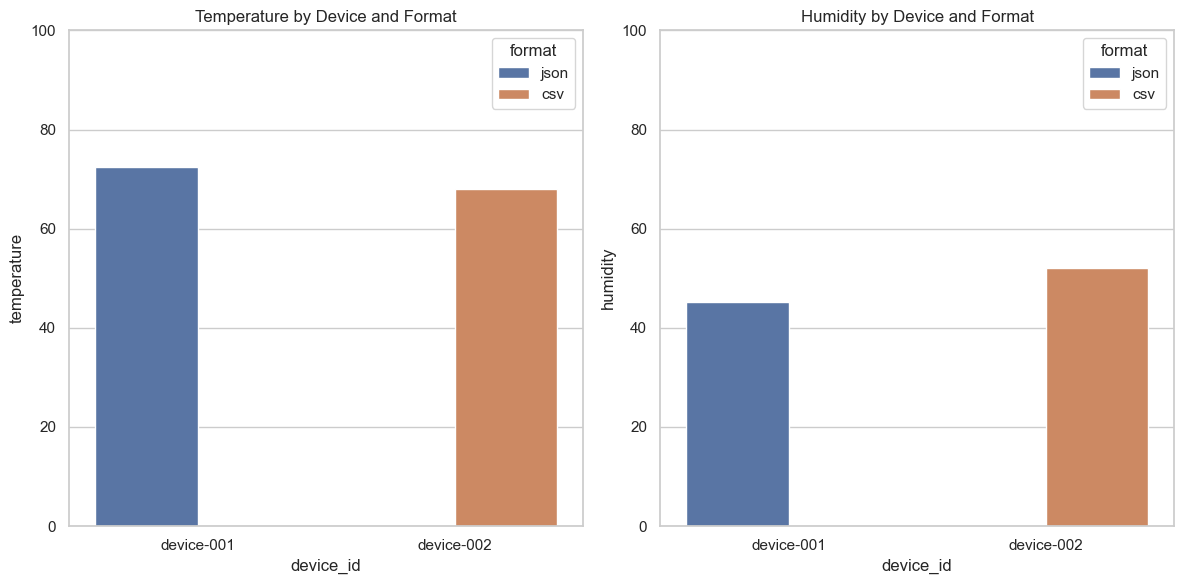

In [8]:
def visualize_results(s3_results):
    """Create visualizations of the processed data"""
    if not s3_results:
        print("No results to visualize.")
        return
    
    # Extract data for visualization
    records = []
    
    for format_type, data in s3_results.items():
        if format_type != 'error' and 'readings' in data['content']:
            record = {
                'device_id': data['content']['device_id'],
                'format': data['content']['original_format']
            }
            
            # Add readings
            for reading_type, value in data['content']['readings'].items():
                record[reading_type] = value
            
            records.append(record)
    
    if not records:
        print("No valid records to visualize.")
        return
    
    # Create DataFrame
    df = pd.DataFrame(records)
    display(df)
    
    # Create visualization
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    # Plot temperature by device and format
    plt.subplot(1, 2, 1)
    sns.barplot(x='device_id', y='temperature', hue='format', data=df)
    plt.title('Temperature by Device and Format')
    plt.ylim(0, 100)
    
    # Plot humidity by device and format
    plt.subplot(1, 2, 2)
    sns.barplot(x='device_id', y='humidity', hue='format', data=df)
    plt.title('Humidity by Device and Format')
    plt.ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

# Visualize the results
visualize_results(s3_results)

## Simulating a Continuous Data Stream

Let's send a continuous stream of mixed-format data to simulate a real-world streaming scenario.

Sending 10 data points at 2 second intervals...
Sent BINARY data for device-001: Temperature=77.8, Humidity=56.0
Sent BINARY data for device-004: Temperature=67.1, Humidity=43.3
Sent BINARY data for device-005: Temperature=71.8, Humidity=32.5
Sent JSON data for device-002: Temperature=78.0, Humidity=36.9
Sent BINARY data for device-003: Temperature=62.5, Humidity=67.5
Sent JSON data for device-002: Temperature=62.1, Humidity=68.6
Sent CSV data for device-001: Temperature=68.8, Humidity=32.7
Sent CSV data for device-003: Temperature=71.0, Humidity=59.3
Sent BINARY data for device-005: Temperature=76.5, Humidity=37.1
Sent BINARY data for device-001: Temperature=87.6, Humidity=59.6

Sent 10 data points: 2 JSON, 2 CSV, 6 Binary

Waiting for Lambda to process the data (30 seconds)...
Checking S3 for processed files...
Found json data: json/year=2025/month=03/day=11/hour=16/device-001-1741709581.json
Found csv data: csv/year=2025/month=03/day=11/hour=16/device-002-1741709581.json


,device_id,format,temperature,humidity
0,device-001,json,72.5,45.2
1,device-002,csv,68.0,52.1


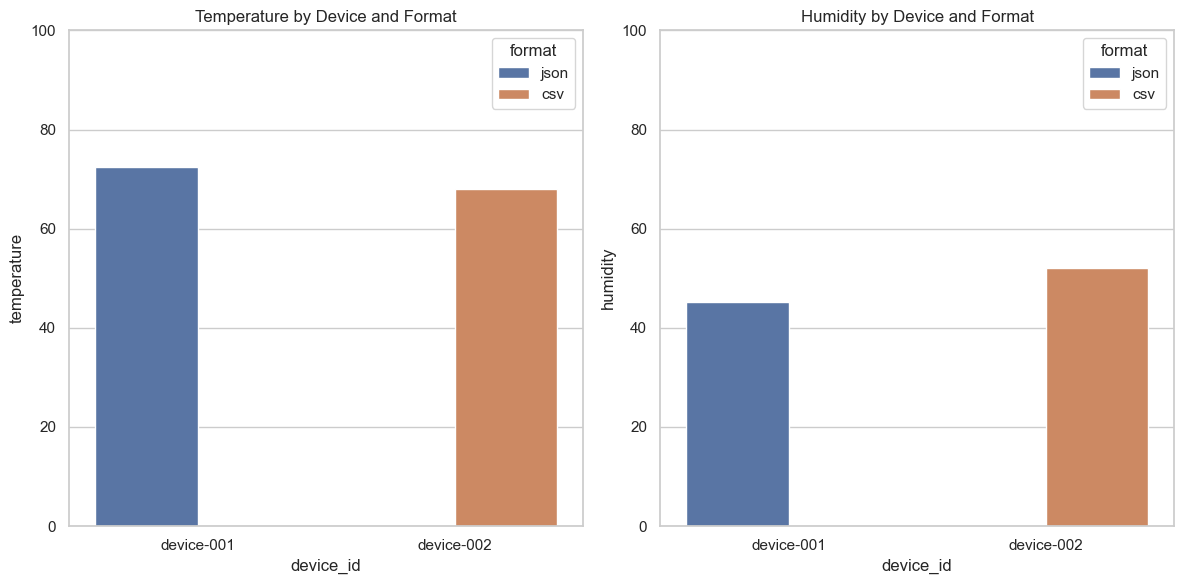

In [9]:
def simulate_data_stream(count=20, interval=1.0):
    """Simulate a continuous stream of data in multiple formats"""
    import random
    
    formats = []
    
    try:
        print(f"Sending {count} data points at {interval} second intervals...")
        
        for i in range(count):
            # Generate random device and readings
            device_id = f"device-{random.randint(1, 5):03d}"
            temperature = round(random.uniform(60, 90), 1)
            humidity = round(random.uniform(30, 70), 1)
            
            # Choose a random format
            format_choice = random.choice(['json', 'csv', 'binary'])
            formats.append(format_choice)
            
            if format_choice == 'json':
                data = generate_json_data(device_id, temperature, humidity)
                partition_key = f"json-{device_id}"
            elif format_choice == 'csv':
                data = generate_csv_data(device_id, temperature, humidity)
                partition_key = f"csv-{device_id}"
            else:
                data = generate_binary_data(device_id, temperature, humidity)
                partition_key = f"binary-{device_id}"
            
            # Send to Kinesis
            response = send_to_kinesis(data, partition_key)
            
            print(f"Sent {format_choice.upper()} data for {device_id}: Temperature={temperature}, Humidity={humidity}")
            
            # Wait for the interval
            time.sleep(interval)
            
        print(f"\nSent {count} data points: {formats.count('json')} JSON, {formats.count('csv')} CSV, {formats.count('binary')} Binary")
        
    except KeyboardInterrupt:
        print("\nData simulation interrupted.")
    except Exception as e:
        print(f"Error simulating data: {str(e)}")

# Simulate a stream of data (10 points at 2-second intervals)
simulate_data_stream(count=10, interval=2)

# Wait for processing
print("\nWaiting for Lambda to process the data (30 seconds)...")
time.sleep(30)

# Check S3 for new results
s3_results = check_s3_results()

# Visualize the updated results
visualize_results(s3_results)

## Cleanup AWS Resources

To avoid ongoing charges, let's clean up all the AWS resources we created.

In [10]:
def cleanup_aws_resources():
    """Clean up all AWS resources created for this demo"""
    
    try:
        print("Cleaning up AWS resources...")
        
        # Delete Lambda event source mapping
        print("Deleting Lambda event source mappings...")
        mappings = lambda_client.list_event_source_mappings(
            FunctionName=LAMBDA_FUNCTION_NAME,
            EventSourceArn=f"arn:aws:kinesis:{session.region_name}:{boto3.client('sts').get_caller_identity()['Account']}:stream/{STREAM_NAME}"
        )
        
        for mapping in mappings.get('EventSourceMappings', []):
            lambda_client.delete_event_source_mapping(
                UUID=mapping['UUID']
            )
        
        # Delete Lambda function
        print(f"Deleting Lambda function: {LAMBDA_FUNCTION_NAME}")
        lambda_client.delete_function(
            FunctionName=LAMBDA_FUNCTION_NAME
        )
        
        # Delete IAM role policies
        print(f"Detaching IAM policies from role: {LAMBDA_ROLE_NAME}")
        iam_client.detach_role_policy(
            RoleName=LAMBDA_ROLE_NAME,
            PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole'
        )
        
        iam_client.detach_role_policy(
            RoleName=LAMBDA_ROLE_NAME,
            PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaKinesisExecutionRole'
        )
        
        iam_client.detach_role_policy(
            RoleName=LAMBDA_ROLE_NAME,
            PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess'
        )
        
        # Delete IAM role
        print(f"Deleting IAM role: {LAMBDA_ROLE_NAME}")
        iam_client.delete_role(
            RoleName=LAMBDA_ROLE_NAME
        )
        
        # Delete S3 bucket contents
        print(f"Emptying S3 bucket: {S3_BUCKET_NAME}")
        bucket = boto3.resource('s3').Bucket(S3_BUCKET_NAME)
        bucket.objects.all().delete()
        
        # Delete S3 bucket
        print(f"Deleting S3 bucket: {S3_BUCKET_NAME}")
        s3_client.delete_bucket(
            Bucket=S3_BUCKET_NAME
        )
        
        # Delete Kinesis stream
        print(f"Deleting Kinesis stream: {STREAM_NAME}")
        kinesis_client.delete_stream(
            StreamName=STREAM_NAME,
            EnforceConsumerDeletion=True
        )
        
        print("All AWS resources have been cleaned up successfully.")
        
    except Exception as e:
        print(f"Error cleaning up resources: {str(e)}")
        print("You may need to manually delete some resources from the AWS Console.")

# Uncomment this line when you want to clean up all resources
cleanup_aws_resources()

Cleaning up AWS resources...
Deleting Lambda event source mappings...
Deleting Lambda function: multi-format-processor-7855382b
Detaching IAM policies from role: multi-format-lambda-role-7855382b
Deleting IAM role: multi-format-lambda-role-7855382b
Emptying S3 bucket: multi-format-demo-7855382b
Deleting S3 bucket: multi-format-demo-7855382b
Deleting Kinesis stream: multi-format-stream-7855382b
All AWS resources have been cleaned up successfully.


## Conclusion

In this notebook, we've built a complete AWS streaming pipeline that can handle multiple data formats:

1. **AWS Infrastructure Setup**:
   - Kinesis Data Stream for ingestion
   - Lambda function for processing
   - S3 bucket for storing results
   - IAM roles for permissions

2. **Multi-format Data Processing**:
   - Generating data in JSON, CSV, and binary formats
   - Automatic format detection based on content
   - Format-specific processing logic
   - Standardized output structure

3. **Real-time Monitoring**:
   - CloudWatch metrics for stream and Lambda
   - Visualizations of processed data

4. **Key AWS Streaming Concepts**:
   - Stream-based data ingestion
   - Event-driven processing with Lambda
   - Partitioned storage in S3
   - Monitoring with CloudWatch

This pattern can be extended to handle other formats and integrated with additional AWS services like DynamoDB, SQS, or Glue for more complex streaming applications. The core approach—detect, process, standardize—remains consistent regardless of scale.

## Additional Resources

- [AWS Kinesis Developer Guide](https://docs.aws.amazon.com/kinesis/latest/dev/introduction.html)
- [AWS Lambda Developer Guide](https://docs.aws.amazon.com/lambda/latest/dg/welcome.html)
- [Stream Processing with AWS Services](https://aws.amazon.com/streaming-data/)